
 # WatsonX Basic Multi-agent Collaboration

 A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools.

 One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert".

 This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.



The resulting graph will look something like the following diagram:

![multi_agent diagram](./img/simple_multi_agent_diagram.png)

Before we get started, a quick note: this and other multi-agent notebooks are designed to show _how_ you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

In [1]:
import logging
from typing import Any, Dict, List, Optional, Sequence, Type, Union, Callable, Literal
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import LLMResult, Generation, GenerationChunk
from langchain_core.messages import BaseMessage
from langchain_core.language_models import LanguageModelInput
from dotenv import load_dotenv
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
import os
import getpass

logger = logging.getLogger(__name__)

# Simplified loading of environment variables and IBM connection parameters
load_dotenv()

def set_env(var: str):
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

class IbmConnectionParams(BaseModel):
    api_key: str
    project_id: str
    url: str
    credentials: dict[str, str]

    def __init__(self, api_key: str, project_id: str, url: str) -> None:
        super().__init__(api_key=api_key, project_id=project_id, url=url, credentials={"url": url, "apikey": api_key})

# Set IBM connection parameters
ibm_params = IbmConnectionParams(
    api_key=set_env("WATSONX_API_KEY"),
    project_id=set_env("PROJECT_ID"),
    url = set_env("WATSONX_URL")
)

parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 1000,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}

class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models."""
    # Define the default parameters as class variables
    DEFAULT_MODEL_ID = "ibm/granite-13b-instruct-v2"
    DEFAULT_URL = ibm_params.url
    DEFAULT_APIKEY = ibm_params.api_key
    DEFAULT_PROJECT_ID = ibm_params.project_id
    DEFAULT_PARAMS = parameters    
    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)

    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, model_id: Optional[str] = None, **kwargs):
        if not model_id and 'deployment_id' not in kwargs:
            raise ValueError("One of 'model_id' or 'deployment_id' parameters should be set.")
        super().__init__(model_id=model_id, *args, **kwargs)
        self.bound_tools = tools or []

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
    ) -> LLMResult:
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(f"WatsonxLLM currently only supports single prompt, got {prompts}")
            generation = GenerationChunk(text="")
            stream_iter = self._stream(prompts[0], stop=stop, run_manager=run_manager, **kwargs)
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
        else:
            print("Step 1 - Starting Tool Evaluation")
                        
            if self.bound_tools:
                print("Step 1.1 self.bound_tools")
                print("type(self.bound_tools)", type(self.bound_tools)) 
                print("self.bound_tools", self.bound_tools)
                
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])
                logger.info("Tool output: %s", tool_output)

                system_prompt = (
                    f"You are an assistant with access to web search results. "
                    f"Provide a detailed answer to the user's query.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Using the information below:\n"
                    f"Web Search Results: {tool_output}\n\n"
                )
                prompts[0] = system_prompt

            print("prompts", prompts)

            if not isinstance(params, dict):
                raise ValueError(f"Expected params to be a dictionary, got {type(params)}")

            response = self.watsonx_model.generate(prompt=prompts, params=params, **kwargs)
            return self._create_llm_result(response)


    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        combined_output = []
        print(f"Debug: Starting tool evaluation for input: {input_text}")
        print("tool_instances:", tool_instances)

        for tool in tool_instances:
            try:
                # Invoke the tool with the provided input
                result = tool.invoke(input_text)
                print(f"Debug: Result from tool {tool.name}: {result}")

                # Check the type of result and handle it accordingly
                if isinstance(result, str):
                    content = f"WebSearch Results: {result}"
                elif isinstance(result, list) and all(isinstance(item, dict) for item in result):
                    content = "WebSearch Results: " + " ".join(item.get('content', '') for item in result)
                elif isinstance(result, dict):
                    content = "WebSearch Results: " + result.get('content', 'Unknown response format')
                else:
                    content = "WebSearch Results: Invalid format received from tool"

                # Append the processed content to the combined output
                combined_output.append(content)

            except Exception as e:
                error_message = f"Error invoking tool {tool.name}: {str(e)}"
                print(f"Debug: {error_message}")
                combined_output.append(error_message)

        final_output = "\n\n".join(combined_output)
        print(f"Debug: Final combined output: {final_output}")
        return final_output

    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        model_id: Optional[str] = None,
        url: Optional[str] = None,
        apikey: Optional[str] = None,
        project_id: Optional[str] = None,
        params: Optional[Dict[str, Any]] = None,
        tool_choice: Optional[Union[Dict[str, str], Literal["any", "auto"], str]] = None,
        **kwargs: Any,
    ) -> 'WatsonxLLM':
        formatted_tools = [convert_to_openai_tool(tool)["function"] for tool in tools]
        # Initialize WatsonxLLM with the provided parameters
        instance = cls(
            model_id=model_id,
            url=url,
            apikey=apikey,
            project_id=project_id,
            params=params,
            **kwargs
        )
        instance.bound_tools = tools
        if tool_choice is not None:
            kwargs["tool_choice"] = tool_choice
        return instance

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)

# Example usage:
tool = TavilySearchResults(max_results=4)

# Bind the tool and pass all necessary parameters inside `bind_tools`
llm_with_tools = WatsonxLLM.bind_tools(
    tools=[tool],
    model_id="ibm/granite-13b-instruct-v2",
    url=ibm_params.url,
    apikey=ibm_params.api_key,
    project_id=ibm_params.project_id,
    params=parameters
)
# Invoke the model
response = llm_with_tools.invoke("Who is Ruslan Magana?")
print(response)


Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults(max_results=4)]
Debug: Starting tool evaluation for input: Who is Ruslan Magana?
tool_instances: [TavilySearchResults(max_results=4)]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://medium.com/@ruslanmv', 'content': 'Read writing from Ruslan Magana Vsevolodovna on Medium. Machine Learning Engineer & Data Scientist & Physicist. Every day, Ruslan Magana Vsevolodovna and\xa0...'}, {'url': 'https://www.linkedin.com/posts/ruslanmv_ibm-meta-activity-7187526652833255425-9yOS', 'content': "Apr 20, 2024 · Ruslan Magana Vsevolodovna, PhD's Post ... I'm so excited about the release of Meta's new Llama 3 language models on #watsonx.ai. This, combined\xa0..."}, {'url': 'https://ruslanmv.com/?srsltid=AfmBOordgkRQ8b-OSBhagE-_Xhn3Z1rmBY1VjGT6ckAthEFv21bWq9w7', 'content': 'Ruslan Magana Vsevolodovna, Artificial Intelligence, Data Science, Machine 

In [8]:
# Example usage:
tool = TavilySearchResults(max_results=4)
llm_with_tools = WatsonxLLM.bind_tools(
    tools=[tool],
    model_id="ibm/granite-13b-instruct-v2",
    url=ibm_params.url,
    apikey=ibm_params.api_key,
    project_id=ibm_params.project_id,
    params=parameters    
)  
response = llm_with_tools.invoke("Who is Ruslan Magana?")
print(response) 

Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults(max_results=4)]
Debug: Starting tool evaluation for input: Who is Ruslan Magana?
tool_instances: [TavilySearchResults(max_results=4)]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://ruslanmv.com/about', 'content': "I'm Ruslan Magana Vsevolodovna. I'm a Data Scientist, a Cloud Architect and a Physicist. About me. I am Data Scientist specializing in Artificial Intelligence, with a distinct focus on Neural Networks. My core expertise lies in Generative AI and prompt engineering. I possess a strong commitment to precision and boast an extensive track ..."}, {'url': 'https://scholar.google.com/citations?user=rWBrOpwAAAAJ', 'content': 'Ruslan Magana Vsevolodovna. National Institute for Nuclear Physics. Verified email at ge.infn.it - Homepage. Nuclear Physics Machine Learning Data Science Cloud Computing Big Data. ... R Magana, H Zheng, 

In [9]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    print("Tools defined:", tools)
    print("prompt:",  prompt)
    return prompt | llm.bind_tools(     
        tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters  
        )


In [10]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_tool = TavilySearchResults(max_results=4)
# Warning: This executes code locally, which can be unsafe when not sandboxed
repl = PythonREPL()

In [11]:
@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [12]:
# ## Create graph
import functools
from langchain_core.messages import AIMessage

In [13]:
# Helper function to create a node for a given agent
def agent_node_old(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        "sender": name,
    }

In [14]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    
    print(f"Debug: Agent {name} invoked with state: {state}")
    print(f"Debug: Result from agent {name}: {result}")
    # Check if result has a dict method (indicating it's not a simple string)
    if hasattr(result, 'dict'):
        # If it's an object with a dict method, convert it to the appropriate format
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    else:
        # If result is a string, construct an AIMessage with the text
        result = AIMessage(content=str(result), name=name)
    return {
        "messages": [result],
        "sender": name,
    }


In [15]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# Research agent and node
research_agent = create_agent(
    WatsonxLLM,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")


Tools defined: [TavilySearchResults(max_results=4)]
prompt: input_variables=['messages'] input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]} partial_variables={'system_message': 'You should provide accurate data for the chart_generator to use.', 'tool_names': 'tavily_search_results_json'} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['system_message', 'tool_names'], template="You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants

In [16]:
# chart_generator
chart_agent = create_agent(
    WatsonxLLM,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")


Tools defined: [StructuredTool(name='python_repl', description='Use this to execute python code. If you want to see the output of a value,\n    you should print it out with `print(...)`. This is visible to the user.', args_schema=<class 'pydantic.v1.main.python_replSchema'>, func=<function python_repl at 0x7f89d09f5cf0>)]
prompt: input_variables=['messages'] input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]} partial_variables={'system_message': 'Any charts you display will be visible by the user.', 'tool_names': 'python_repl'} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['system_message', 'tool_names'], template="You are a helpful AI assistant, collaborating with other assistants. Use the provide

In [17]:
from langgraph.prebuilt import ToolNode
tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)
print(tools)

[TavilySearchResults(max_results=4), StructuredTool(name='python_repl', description='Use this to execute python code. If you want to see the output of a value,\n    you should print it out with `print(...)`. This is visible to the user.', args_schema=<class 'pydantic.v1.main.python_replSchema'>, func=<function python_repl at 0x7f89d09f5cf0>)]


In [18]:
print(tool_node)

tools(recurse=True, tools_by_name={'tavily_search_results_json': TavilySearchResults(max_results=4), 'python_repl': StructuredTool(name='python_repl', description='Use this to execute python code. If you want to see the output of a value,\n    you should print it out with `print(...)`. This is visible to the user.', args_schema=<class 'pydantic.v1.main.python_replSchema'>, func=<function python_repl at 0x7f89d09f5cf0>)}, handle_tool_errors=True)


In [19]:
# ## Define Edge Logic
# %%
from typing import Literal
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]
    last_message = messages[-1]
    print(f"Debug: Last message in state: {last_message}")

    if last_message.tool_calls:
        print("Debug: Routing to call_tool")
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"
    print("Debug: Continuing to next node")
    return "continue"


In [20]:
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
import operator
from typing import Annotated, Sequence, TypedDict
# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [21]:
from langgraph.graph import END, StateGraph
# ## Define the Graph
# %%
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)
workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)


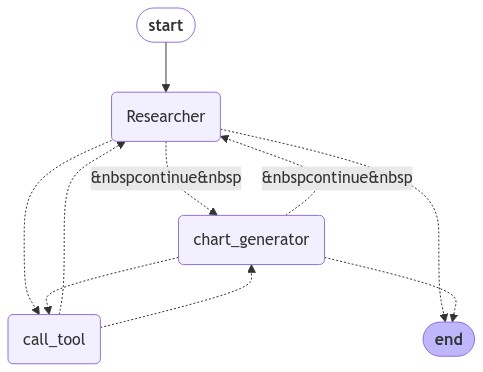

In [22]:
# Make sure the graph is initialized properly with a valid entry point
workflow.set_entry_point("Researcher")  # Set the entry point of the graph
# Compile the workflow to prepare it for execution
graph = workflow.compile()
from IPython.display import Image, display
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [23]:
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)

In [26]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")


Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults(max_results=4)]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop. You have access to the following tools: tavily_search_results_json.
You should provide accurate data for the chart_generator to use.
Human: Fetch the UK's GDP over the past 5 years, then draw a line graph of it. Once you code it up, finish.
tool_instances: [TavilySearchResults(max_results=4)]
Debug: Result from tool tavily_search_results_json: HTTPError('400 Cli

Python REPL can execute arbitrary code. Use with caution.


Debug: Agent Researcher invoked with state: {'messages': [HumanMessage(content="Fetch the UK's GDP over the past 5 years, then draw a line graph of it. Once you code it up, finish.")], 'sender': None}
Debug: Result from agent Researcher:  Final Answer:400 Client Error: Bad Request for url: https://api.tavily.com/search

Using the information below:
Web Search Results: WebSearch Results: HTTPError('400 Client Error: Bad Request for url: https://api.tavily.com/search')



Debug: Last message in state: content=" Final Answer:400 Client Error: Bad Request for url: https://api.tavily.com/search\n\nUsing the information below:\nWeb Search Results: WebSearch Results: HTTPError('400 Client Error: Bad Request for url: https://api.tavily.com/search')\n\n\n" name='Researcher'
Debug: Continuing to next node
{'Researcher': {'messages': [AIMessage(content=" Final Answer:400 Client Error: Bad Request for url: https://api.tavily.com/search\n\nUsing the information below:\nWeb Search Results: WebSearch

In [25]:
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
import operator
from typing import Annotated, Sequence, TypedDict
# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [29]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
import functools
from typing import Annotated, Literal

# Tool Initialization
tavily_tool = TavilySearchResults(max_results=4)
repl = PythonREPL()

# Define Python REPL Tool
@tool
def python_repl(code: Annotated[str, "The python code to execute to generate your chart."]):
    """
    Execute Python code and return the result.

    This tool runs the provided Python code in a REPL environment and returns the standard output.
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}\n\nIf you have completed all tasks, respond with FINAL ANSWER."

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to answer the question. If you can't answer fully, another assistant will help."
                " Prefix final responses with FINAL ANSWER.\nTools available: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message, tool_names=", ".join([tool.name for tool in tools]))
    
    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )

# Function to invoke agents and handle their results
def agent_node(state, agent, name):
    result = agent.invoke(state)
    
    # Handle different result types
    if hasattr(result, 'dict'):
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    else:
        result = AIMessage(content=str(result), name=name)
    
    return {
        "messages": [result],
        "sender": name,
    }

# Define agents and their nodes
research_agent = create_agent(
    WatsonxLLM, [tavily_tool], system_message="Provide accurate data for the chart generator."
)
chart_agent = create_agent(
    WatsonxLLM, [python_repl], system_message="Any charts you display will be visible to the user."
)

research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")
chart_node = functools.partial(agent_node, agent=chart_agent, name="ChartGenerator")

# Create tool node
tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

# Define router for graph transitions
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    last_message = state["messages"][-1]
    
    if last_message.tool_calls:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    return "continue"

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("ChartGenerator", chart_node)
workflow.add_node("call_tool", tool_node)
workflow.add_conditional_edges("Researcher", router, {"continue": "ChartGenerator", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("ChartGenerator", router, {"continue": "Researcher", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("call_tool", lambda x: x["sender"], {"Researcher": "Researcher", "ChartGenerator": "ChartGenerator"})

# Set the entry point of the workflow
workflow.set_entry_point("Researcher")

# Compile the workflow for execution
graph = workflow.compile()

# Execute the graph stream with a test message
events = graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the UK's GDP over the past 2 years, then draw a line graph of it.")
        ]
    },
    {"recursion_limit": 150}
)

# Output the results
for s in events:
    print(s)
    print("----")


Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults(max_results=4)]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to answer the question. If you can't answer fully, another assistant will help. Prefix final responses with FINAL ANSWER.
Tools available: tavily_search_results_json.
Provide accurate data for the chart generator.
Human: Fetch the UK's GDP over the past 2 years, then draw a line graph of it.
tool_instances: [TavilySearchResults(max_results=4)]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://www.ons.gov.uk/economy/grossdomesticproductgdp/bulletins/gdpfirstquarterlyestimateuk/januarytomarch2024', 'content': 'As explained in our previous release, UK GDP is estimated to have increased by 0.1% in 2023, following growth of 4.3% in 2022. Data up to 2021 have been reconciled through

In [1]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
import functools
from typing import Annotated, Literal, Sequence
import operator
import re

# Tool Initialization
tavily_tool = TavilySearchResults(max_results=4)
repl = PythonREPL()

# Define Python REPL Tool
@tool
def python_repl(code: Annotated[str, "The python code to execute to generate your chart."]):
    """
    Execute Python code and return the result.

    This tool runs the provided Python code in a REPL environment and returns the standard output.
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}\n\nIf you have completed all tasks, respond with FINAL ANSWER."

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to answer the question. If you can't answer fully, another assistant will help."
                " Prefix final responses with FINAL ANSWER.\nTools available: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message, tool_names=", ".join([tool.name for tool in tools]))
    
    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )

# Function to invoke agents and handle their results
def agent_node(state, agent, name):
    result = agent.invoke(state)
    
    print(f"Debug: Agent {name} invoked with state: {state}")
    print(f"Debug: Result from agent {name}: {result}")
    
    # Filter Python code when invoking chart generator
    if name == "ChartGenerator":
        result = filter_python_code(result)

    # Handle different result types
    if hasattr(result, 'dict'):
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    else:
        result = AIMessage(content=str(result), name=name)
    
    return {
        "messages": [result],
        "sender": name,
    }

# Function to filter Python code from the agent response
def filter_python_code(result):
    """
    Extract valid Python code from the AI-generated response.
    """
    # Search for Python code blocks enclosed within triple backticks
    code_block = re.search(r"```python\n(.*?)```", str(result), re.DOTALL)
    
    if code_block:
        return code_block.group(1)  # Return the Python code inside the code block
    else:
        return "No valid Python code found."

# Define agents and their nodes
research_agent = create_agent(
    WatsonxLLM, [tavily_tool], system_message="Provide accurate data for the chart generator."
)
chart_agent = create_agent(
    WatsonxLLM, [python_repl], system_message="Any charts you display will be visible to the user."
)

research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")
chart_node = functools.partial(agent_node, agent=chart_agent, name="ChartGenerator")

# Create tool node
tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

# Define router for graph transitions
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    last_message = state["messages"][-1]
    
    if last_message.tool_calls:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    return "continue"

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("ChartGenerator", chart_node)
workflow.add_node("call_tool", tool_node)
workflow.add_conditional_edges("Researcher", router, {"continue": "ChartGenerator", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("ChartGenerator", router, {"continue": "Researcher", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("call_tool", lambda x: x["sender"], {"Researcher": "Researcher", "ChartGenerator": "ChartGenerator"})

# Set the entry point of the workflow
workflow.set_entry_point("Researcher")

# Compile the workflow for execution
graph = workflow.compile()

# Execute the graph stream with a test message
events = graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the UK's GDP over the past 5 years, then draw a line graph of it.")
        ]
    },
    {"recursion_limit": 150}
)

# Output the results
for s in events:
    print(s)
    print("----")





NameError: name 'WatsonxLLM' is not defined

In [10]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
import functools
import re
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
import operator
from typing import Annotated, Sequence, TypedDict
# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
# Tool Initialization
tavily_tool = TavilySearchResults(max_results=4)
repl = PythonREPL()

# Define Python REPL Tool
@tool
def python_repl(code: Annotated[str, "The Python code to execute to generate your chart."]):
    """
    Use this tool to execute Python code. If you want to see the output of a value,
    you should print it out with print(...). This is visible to the user.
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\n\nStdout: {result}"
    return result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to answer the question. If you can't answer fully, another assistant will help."
                " Prefix final responses with FINAL ANSWER.\nTools available: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message, tool_names=", ".join([tool.name for tool in tools]))
    
    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )

# Extract Python code from the result
def filter_python_code(result):
    """
    Extract valid Python code from the AI-generated response.
    Looks for code blocks enclosed within triple backticks (```python ... ```).
    """
    code_block = re.search(r"```python\n(.*?)```", str(result), re.DOTALL)
    if code_block:
        return code_block.group(1)  # Return the Python code inside the code block
    else:
        return "No valid Python code found."

# Function to invoke agents and handle their results
def agent_node(state, agent, name):
    result = agent.invoke(state)
    
    print(f"Debug: Agent {name} invoked with state: {state}")
    print(f"Debug: Result from agent {name}: {result}")

    # Filter Python code if invoking the chart generator
    if name == "chart_generator":
        result = filter_python_code(result)

    # Handle different result types
    if hasattr(result, 'dict'):
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    else:
        result = AIMessage(content=str(result), name=name)
    
    return {
        "messages": [result],
        "sender": name,
    }

# Define agents and their nodes
research_agent = create_agent(
    WatsonxLLM, [tavily_tool], system_message="Provide accurate data for the chart generator."
)
chart_agent = create_agent(
    WatsonxLLM, [python_repl], system_message="Any charts you display will be visible to the user."
)

research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

# Create tool node
tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

# Define router for graph transitions
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    last_message = state["messages"][-1]
    print(f"Debug: Last message in state: {last_message}")
    
    if last_message.tool_calls:
        print("Debug: Routing to call_tool")
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"
    print("Debug: Continuing to next node")
    return "continue"

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)
workflow.add_conditional_edges("Researcher", router, {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("chart_generator", router, {"continue": "Researcher", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("call_tool", lambda x: x["sender"], {"Researcher": "Researcher", "chart_generator": "chart_generator"})

# Set the entry point of the workflow
workflow.set_entry_point("Researcher")

# Compile the workflow for execution
graph = workflow.compile()

# Execute the graph stream with a test message
events = graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the UK's GDP over the past 5 years, then draw a line graph of it.")
        ]
    },
    {"recursion_limit": 150}
)

# Output the results
for s in events:
    print(s)
    print("----")


Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults(max_results=4)]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to answer the question. If you can't answer fully, another assistant will help. Prefix final responses with FINAL ANSWER.
Tools available: tavily_search_results_json.
Provide accurate data for the chart generator.
Human: Fetch the UK's GDP over the past 5 years, then draw a line graph of it.
tool_instances: [TavilySearchResults(max_results=4)]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://tradingeconomics.com/united-kingdom/gdp', 'content': 'The Gross Domestic Product (GDP) in the United Kingdom was worth 3340.03 billion US dollars in 2023, according to official data from the World Bank. The GDP value of the United Kingdom represents 3.17 percent of the world economy. This

Python REPL can execute arbitrary code. Use with caution.


Debug: Agent Researcher invoked with state: {'messages': [HumanMessage(content="Fetch the UK's GDP over the past 5 years, then draw a line graph of it.")], 'sender': None}
Debug: Result from agent Researcher:   GDP per capita, PPP (constant 2017 international $) of the U.K. is $41,547.89.

   GDP per capita, PPP (constant 2011 ...
   Gross domestic product (GDP) of the U.K. is $2.07 trillion.

   Gross domestic product (GDP) of the U.K. is $2.07 trillion.


Debug: Last message in state: content='  GDP per capita, PPP (constant 2017 international $) of the U.K. is $41,547.89.\n\n   GDP per capita, PPP (constant 2011 ...\n   Gross domestic product (GDP) of the U.K. is $2.07 trillion.\n\n   Gross domestic product (GDP) of the U.K. is $2.07 trillion.\n\n' name='Researcher'
Debug: Continuing to next node
{'Researcher': {'messages': [AIMessage(content='  GDP per capita, PPP (constant 2017 international $) of the U.K. is $41,547.89.\n\n   GDP per capita, PPP (constant 2011 ...\n   Gross domes

KeyboardInterrupt: 

In [1]:
import re

def filter_python_code(result):
    """
    Extract all valid Python code blocks from the AI-generated response.
    Looks for code blocks enclosed within triple backticks (```python ... ```).
    Returns a list of code blocks, or a message if none are found.
    """
    # Use regular expressions to extract code from the text
    code_blocks = re.findall(r"```python\s*(.*?)```", str(result), re.DOTALL)
    
    if code_blocks:
        return [code.strip() for code in code_blocks]
    else:
        return "No Python code blocks found." 

# Example usage
example_result = """
Here's some text with Python code:
```python
def my_function(x):
  return x * 2
```

And another code block:
```python
print("Hello, world!")
```
"""

extracted_code = filter_python_code(example_result)

print(extracted_code) 


['def my_function(x):\n  return x * 2', 'print("Hello, world!")']


In [ ]:
@tool
def python_repl_test(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [1]:
from typing import Annotated
from langchain.tools import tool

# Define Python REPL Tool (this would typically be defined elsewhere)
@tool
def python_repl_test(code: Annotated[str, "The python code to execute to generate your chart."]):
    """
    Use this to execute python code. If you want to see the output of a value,
    you should print it out with print(...). This is visible to the user.
    """
    try:
        # This is a simplified example, in a real application you would use a proper REPL library
        exec(code)  
        # In a real REPL, you'd capture and return the output from the executed code
        result = "" 
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\n\nStdout: {result}"
    return result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."


def chatbot_response(user_request):
  """
  Generates a response to the user's request by executing Python code.
  """
  if "sum of numbers" in user_request:
    code = "total = sum(range(1, 11))\nprint(total)"  # Generate code for the request
    result = python_repl_test(code)
    # Extract the output (this would need more robust parsing in a real application)
    output = result.split("Stdout: ")[1].split("\n")[0]  
    return f"The sum of numbers from 1 to 10 is {output}."
  else:
    return "I don't understand your request."

# Example interaction
user_request = "Calculate the sum of numbers from 1 to 10"
print(chatbot_response(user_request))

55
The sum of numbers from 1 to 10 is .


/mnt/c/Blog/WatsonX-Multi-Agent-System-with-Langraph/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:151: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use invoke instead.
  warn_deprecated(


In [6]:
from typing import Annotated
from langchain.tools import tool
# Define Python REPL Tool (this would typically be defined elsewhere)
@tool
def python_repl_test(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        # This is a simplified example, in a real application you would use a proper REPL library
        exec(code)  
        # In a real REPL, you'd capture and return the output from the executed code
        result = "" 
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


def chatbot_response(user_request):
  """
  Generates a response to the user's request by executing Python code.
  """
  if "create a list" in user_request:
    # Extract the numbers from the user's request (this would need more robust parsing in a real application)
    numbers = [int(num) for num in user_request.split() if num.isdigit()] 
    code = f"my_list = {numbers}\nprint(my_list)"
    result = python_repl_test(code)
    return result
  else:
    return "I don't understand your request."

# Example interaction
user_request = "create a list 1 2 5"
print(chatbot_response(user_request))

[1, 2, 5]
Successfully executed:
```python
my_list = [1, 2, 5]
print(my_list)
```
Stdout: 

If you have completed all tasks, respond with FINAL ANSWER.


In [12]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
import functools
import re
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
import operator
from typing import Annotated, Sequence, TypedDict
# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
# Tool Initialization
tavily_tool = TavilySearchResults(max_results=4)
repl = PythonREPL()

# Define Python REPL Tool
from typing import Annotated
from langchain.tools import tool
# Define Python REPL Tool (this would typically be defined elsewhere)
@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        # This is a simplified example, in a real application you would use a proper REPL library
        exec(code)  
        # In a real REPL, you'd capture and return the output from the executed code
        result = "" 
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to answer the question. If you can't answer fully, another assistant will help."
                " Prefix final responses with FINAL ANSWER.\nTools available: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message, tool_names=", ".join([tool.name for tool in tools]))
    
    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )

# Extract Python code from the result
def filter_python_code(result):
    """
    Extract all valid Python code blocks from the AI-generated response.
    Looks for code blocks enclosed within triple backticks (```python ... ```).
    Returns a list of code blocks, or a message if none are found.
    """
    # Use regular expressions to extract code from the text
    code_blocks = re.findall(r"```python\s*(.*?)```", str(result), re.DOTALL)
    
    if code_blocks:
        return [code.strip() for code in code_blocks]
    else:
        return "No Python code blocks found." 
   

# Function to invoke agents and handle their results
def agent_node(state, agent, name):
    result = agent.invoke(state)
    
    print(f"Debug: Agent {name} invoked with state: {state}")
    print(f"Debug: Result from agent {name}: {result}")

    # Filter Python code if invoking the chart generator
    if name == "chart_generator":
        result = filter_python_code(result)

    # Handle different result types
    if hasattr(result, 'dict'):
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    else:
        result = AIMessage(content=str(result), name=name)
    
    return {
        "messages": [result],
        "sender": name,
    }

# Define agents and their nodes
research_agent = create_agent(
    WatsonxLLM, [tavily_tool], system_message="Provide accurate data for the chart generator."
)
chart_agent = create_agent(
    WatsonxLLM, [python_repl], system_message="Any charts you display will be visible to the user."
)

research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

# Create tool node
tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

# Define router for graph transitions
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    last_message = state["messages"][-1]
    print(f"Debug: Last message in state: {last_message}")
    
    if last_message.tool_calls:
        print("Debug: Routing to call_tool")
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"
    print("Debug: Continuing to next node")
    return "continue"

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)
workflow.add_conditional_edges("Researcher", router, {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("chart_generator", router, {"continue": "Researcher", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("call_tool", lambda x: x["sender"], {"Researcher": "Researcher", "chart_generator": "chart_generator"})

# Set the entry point of the workflow
workflow.set_entry_point("Researcher")

# Compile the workflow for execution
graph = workflow.compile()

# Execute the graph stream with a test message
events = graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the Gold price over the past 5 days, then draw a line graph of it.")
        ]
    },
    {"recursion_limit": 150}
)

# Output the results
for s in events:
    print(s)
    print("----")


Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults(max_results=4)]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to answer the question. If you can't answer fully, another assistant will help. Prefix final responses with FINAL ANSWER.
Tools available: tavily_search_results_json.
Provide accurate data for the chart generator.
Human: Fetch the Gold price over the past 5 days, then draw a line graph of it.
tool_instances: [TavilySearchResults(max_results=4)]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://www.bullion-rates.com/gold/USD/2024-8-history.htm', 'content': 'Gold Price History in US Dollars (USD) for August 2024. Bullion Prices Gold Prices. Silver Prices. ... 08/09/24: 2,431.08: 78.161: 08/12/24: 2,472.19: 79.483: 08/13/24: 2,465.18: 79.257: 08/14/24: 2,448.16: 78.710: 08/15/24:

In [11]:
# Extract Python code from the result
def filter_python_code(result):
    """
    Extract all valid Python code blocks from the AI-generated response.
    Looks for code blocks enclosed within triple backticks (```python ... ```).
    Returns a list of code blocks, or a message if none are found.
    """
    # Use regular expressions to extract code from the text
    code_blocks = re.findall(r"```python\s*(.*?)```", str(result), re.DOTALL)
    
    if code_blocks:
        return [code.strip() for code in code_blocks]
    else:
        return "No Python code blocks found." 

# Function to invoke agents and handle their results
def agent_node(state, agent, name):
    result = agent.invoke(state)
    
    print(f"Debug: Agent {name} invoked with state: {state}")
    print(f"Debug: Result from agent {name}: {result}")

    # If result contains tool invocations, handle tool output
    if "tool_calls" in result:
        result = result["tool_calls"]

    # Filter Python code if invoking the chart generator
    if name == "chart_generator":
        result = filter_python_code(result)

    # Ensure the result is properly formatted as a message
    if isinstance(result, dict) and hasattr(result, 'dict'):
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    else:
        result = AIMessage(content=str(result), name=name)

    # Update state with new messages
    updated_state = {
        "messages": state["messages"] + [result],
        "sender": name,
    }
    
    return updated_state

# Router for handling state transitions between agents and tools
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    last_message = state["messages"][-1]
    print(f"Debug: Last message in state: {last_message}")
    
    # Check for tool calls in the last message
    if "tool_calls" in last_message.content:
        print("Debug: Routing to call_tool")
        return "call_tool"
    
    # End the workflow if the final answer is found
    if "FINAL ANSWER" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"
    
    # Continue to the next node if there is no tool call or final answer
    print("Debug: Continuing to next node")
    return "continue"

# Set up the agent workflow, handling state propagation
workflow = StateGraph(AgentState)

# Define agent nodes
workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

# Define state transitions
workflow.add_conditional_edges("Researcher", router, {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("chart_generator", router, {"continue": "Researcher", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("call_tool", lambda x: x["sender"], {"Researcher": "Researcher", "chart_generator": "chart_generator"})

# Set the entry point for the workflow
workflow.set_entry_point("Researcher")

# Compile the workflow for execution
graph = workflow.compile()

# Execute the workflow with a test message and ensure consistent state handling
events = graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the Gold price over the past 5 days, then draw a line graph of it.")
        ]
    },
    {"recursion_limit": 150}
)

# Output the results
for s in events:
    print(s)
    print("----")


Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults(max_results=4)]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to answer the question. If you can't answer fully, another assistant will help. Prefix final responses with FINAL ANSWER.
Tools available: tavily_search_results_json.
Provide accurate data for the chart generator.
Human: Fetch the Gold price over the past 5 days, then draw a line graph of it.
tool_instances: [TavilySearchResults(max_results=4)]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://example.com/', 'content': 'Example Domain. This domain is for use in illustrative examples in documents. You may use this domain in literature without prior coordination or asking for permission.'}]
Debug: Final combined output: WebSearch Results: Example Domain. This domain is for use i

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
import functools
import re
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
import operator
from typing import Annotated, Sequence, TypedDict
# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
# Tool Initialization
tavily_tool = TavilySearchResults(max_results=4)
repl = PythonREPL()

# Define Python REPL Tool
from typing import Annotated
from langchain.tools import tool
# Define Python REPL Tool (this would typically be defined elsewhere)
@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        # This is a simplified example, in a real application you would use a proper REPL library
        exec(code)  
        # In a real REPL, you'd capture and return the output from the executed code
        result = "" 
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to answer the question. If you can't answer fully, another assistant will help."
                " Prefix final responses with FINAL ANSWER.\nTools available: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message, tool_names=", ".join([tool.name for tool in tools]))
    
    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )

# Extract Python code from the result
def filter_python_code(result):
    """
    Extract all valid Python code blocks from the AI-generated response.
    Looks for code blocks enclosed within triple backticks (```python ... ```).
    Returns a list of code blocks, or a message if none are found.
    """
    # Use regular expressions to extract code from the text
    code_blocks = re.findall(r"```python\s*(.*?)```", str(result), re.DOTALL)
    
    if code_blocks:
        return [code.strip() for code in code_blocks]
    else:
        return "No Python code blocks found." 

# Function to invoke agents and handle their results
def agent_node(state, agent, name):
    result = agent.invoke(state)
    
    print(f"Debug: Agent {name} invoked with state: {state}")
    print(f"Debug: Result from agent {name}: {result}")

    # If result contains tool invocations, handle tool output
    if "tool_calls" in result:
        result = result["tool_calls"]

    # Filter Python code if invoking the chart generator
    if name == "chart_generator":
        result = filter_python_code(result)

    # Ensure the result is properly formatted as a message
    if isinstance(result, dict) and hasattr(result, 'dict'):
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    else:
        result = AIMessage(content=str(result), name=name)

    # Update state with new messages
    updated_state = {
        "messages": state["messages"] + [result],
        "sender": name,
    }
    
    return updated_state

# Router for handling state transitions between agents and tools
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    last_message = state["messages"][-1]
    print(f"Debug: Last message in state: {last_message}")
    
    # Check for tool calls in the last message
    if "tool_calls" in last_message.content:
        print("Debug: Routing to call_tool")
        return "call_tool"
    
    # End the workflow if the final answer is found
    if "FINAL ANSWER" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"
    
    # Continue to the next node if there is no tool call or final answer
    print("Debug: Continuing to next node")
    return "continue"

# Define agents and their nodes
research_agent = create_agent(
    WatsonxLLM, [tavily_tool], system_message="Provide accurate data for the chart generator."
)
chart_agent = create_agent(
    WatsonxLLM, [python_repl], system_message="Any charts you display will be visible to the user."
)

research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

# Create tool node
tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

# Define router for graph transitions
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    last_message = state["messages"][-1]
    print(f"Debug: Last message in state: {last_message}")
    
    if last_message.tool_calls:
        print("Debug: Routing to call_tool")
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"
    print("Debug: Continuing to next node")
    return "continue"


# Set up the agent workflow, handling state propagation
workflow = StateGraph(AgentState)

# Define agent nodes
workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

# Define state transitions
workflow.add_conditional_edges("Researcher", router, {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("chart_generator", router, {"continue": "Researcher", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("call_tool", lambda x: x["sender"], {"Researcher": "Researcher", "chart_generator": "chart_generator"})

# Set the entry point for the workflow
workflow.set_entry_point("Researcher")


# Compile the workflow for execution
graph = workflow.compile()

# Execute the workflow with a test message and ensure consistent state handling
events = graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the Gold price over the past 5 days, then draw a line graph of it.")
        ]
    },
    {"recursion_limit": 150}
)
# Output the results
for s in events:
    print(s)
    print("----")


Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults(max_results=4)]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to answer the question. If you can't answer fully, another assistant will help. Prefix final responses with FINAL ANSWER.
Tools available: tavily_search_results_json.
Provide accurate data for the chart generator.
Human: Fetch the Gold price over the past 5 days, then draw a line graph of it.
tool_instances: [TavilySearchResults(max_results=4)]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://dev-d9.goldprice.org/gold-price-today/2024-08-10', 'content': 'Aug 10, 2024 · Gold Price on 10 August 2024 ; Gold Price, 2431.20, -0.10 ; Silver Price, 27.46, 0.00 ; Gold/Silver Ratio, 88.52, 0.00 ; Silver/Gold Ratio, 0.01\xa0...'}, {'url': 'https://www.bullionbypost.com/gold-price/gold-